 #                                         MODELLING PREPARATION TIME

# 1. Introduction
The purpose of this notebook is to deliver a preparation time model which could be used to help the restaurants to plan the preparation of orders and to make sure riders arrive at the restaurants at the right time, not too early and not too late. If the model underestimates the preparation time, the riders will be at the restaurant to early resulting in inefficcieny; if the model overestimates the preparation time - the prepared order will unnecessarily wait at the restaurant for the rider to arrive, impacting negatively the customer experience since the customer will not be receiving fresh food.
I will approach this problem as a regression problem because the target is quantitative and continuous.


In this notebook I will first explore the data to better understand the problem and identify cases when the data needs cleaning. Then I will construct features, build a baseline model and then a more sophisticated model to see if it improves the prep time estimation. In the end I will propose potential future work with the purpose of improving the prep time estimation and I will also discuss the business impact that this model will have.

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload

# 2. Data Loading
In this section I load the data and check the size of the dataset and the information contained in the 2 files: `orders.csv` and `restaurants.csv`.
The `orders.csv` file contains data for 32384 orders and the `restaurants.csv` file contains information for 1697 restaurants. The information in the 2 files is connected with the `restaurant_id` column which appears in both files. The dataset is small with 32394 data points.


In [3]:
orders_path = '/Users/Mira/Downloads/Deliveroo Hiring - Test for Machine Learning Engineering/orders.csv.gz'
restaurants_path = '/Users/Mira/Downloads/Deliveroo Hiring - Test for Machine Learning Engineering/restaurants.csv.gz'

orders = load_data(orders_path, parse_dates=['order_acknowledged_at','order_ready_at'])
restaurants = load_data(restaurants_path)

In [4]:
orders.shape, restaurants.shape

((32394, 6), (1697, 4))

In [5]:
orders.head()

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds
0,2015-06-01 12:28:28.952789+01:00,2015-06-01 14:12:09.474896+01:00,59.90,1326,2,6220
1,2015-06-06 17:06:24.434807+01:00,2015-06-06 17:16:27.520253+01:00,24.00,1326,8,603
2,2015-06-08 14:56:15.503204+01:00,2015-06-08 15:03:39.397496+01:00,15.25,1326,3,443
3,2015-06-12 15:12:20.497925+01:00,2015-06-12 15:23:30.064683+01:00,28.05,1326,8,669
4,2015-06-01 13:07:10.794050+01:00,2015-06-01 14:02:25.104517+01:00,56.30,255,7,3314


In [6]:
# compute prep time in minutes because it's easier to read 
orders['prep_time_minutes'] = round(orders['prep_time_seconds'] / 60, 2)

In [7]:
orders.head()

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,prep_time_minutes
0,2015-06-01 12:28:28.952789+01:00,2015-06-01 14:12:09.474896+01:00,59.90,1326,2,6220,103.67
1,2015-06-06 17:06:24.434807+01:00,2015-06-06 17:16:27.520253+01:00,24.00,1326,8,603,10.05
2,2015-06-08 14:56:15.503204+01:00,2015-06-08 15:03:39.397496+01:00,15.25,1326,3,443,7.38
3,2015-06-12 15:12:20.497925+01:00,2015-06-12 15:23:30.064683+01:00,28.05,1326,8,669,11.15
4,2015-06-01 13:07:10.794050+01:00,2015-06-01 14:02:25.104517+01:00,56.30,255,7,3314,55.23


In [8]:
restaurants.head()

,restaurant_id,country,city,type_of_food
0,3,UK,London,thai
1,5,UK,London,italian
2,7,UK,London,italian
3,8,UK,London,chinese
4,9,France,Paris,korean


# 3. Exploratory Data Analysis
In this section I will further explore the dataset with the purpose of performing cleaning procedures or data transformations to improve the quality of the data and to better understand the nature of the data and the underlying relationships. Some takeaways from EDA are:
- `prep_time_seconds` can take extreme values between 0 and 70 hours. I removed 10% of the data (the top 5% and bottom 5% of the values), bringing the range of values from 1.9 to 50 minutes. 1.9 minutes sounds reasonable in cases when the order might be sth that doesn't require any cooking of preparation, e.g. a drink or a packaged sandwich, and 50 minutes sounds reasonable for big orders during busy times. 

- There are 1669 different restaurants
- 50% of the orders have a value lower that 21.5 gbp, have 3 items or less and it takes 13.6 minutes or less to prepare. The distribution of the target and some of the predictors is skewed.

- There are for 4 markets in 4 countries, UK being the biggest one, with 82.14% of all the restaurants and 93.45% of all orders. France tends to have a lower prep time compare to other countries. The vast majority of the cities are in the UK, with London being the biggest one. There are many cities with very few data points.

- There are 82 types of food. Some of them are very infrequent. I decided to put all types of food with less than 30 orders in a new category `others`, resulting in 45 types of food.
 
-  I extracted hour of the day and day of the week from `order_acknowledged_at`. Wednesday tends to have lower prep time, while during the weekend the prep time seems to be higher. During the day the hours before lunch time 11-12 seems to have higher prep times.

In [9]:
orders.replace([np.inf, -np.inf], np.nan).isnull().sum()

order_acknowledged_at    0
order_ready_at           0
order_value_gbp          0
restaurant_id            0
number_of_items          0
prep_time_seconds        0
prep_time_minutes        0
dtype: int64

In [10]:
restaurants.replace([np.inf, -np.inf], np.nan).isnull().sum()

restaurant_id    0
country          0
city             0
type_of_food     0
dtype: int64

There are no missing values in the data.

In [11]:
# every restaurant_id appears only once so the restaurants are unique
restaurants['restaurant_id'].value_counts().sort_values()

3       1
10      1
12      1
13      1
14      1
       ..
3620    1
3576    1
3544    1
3537    1
3622    1
Name: restaurant_id, Length: 1697, dtype: int64

#### Check for outliers

In [12]:
orders.describe()

,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,prep_time_minutes
count,32394.000000,32394.000000,32394.000000,32394.000000,32394.000000
mean,26.547303,1290.555535,4.025715,1299.993857,21.666550
std,19.263851,960.295504,2.392063,4404.573191,73.409556
min,0.500000,3.000000,1.000000,0.000000,0.000000
25%,16.700000,408.000000,3.000000,518.000000,8.630000
50%,21.400000,1160.000000,3.000000,820.000000,13.670000
75%,30.250000,2117.000000,5.000000,1227.000000,20.450000
max,711.000000,3622.000000,38.000000,255499.000000,4258.320000


In [13]:
orders['prep_time_minutes'].quantile(0.95), orders['prep_time_minutes'].quantile(0.99)

(50.35699999999997, 127.23349999999999)

In [14]:
orders['prep_time_minutes'].quantile(0.05), orders['prep_time_minutes'].quantile(0.01)

(1.93, 0.17)

From the descriptive table above it seems that there are outliers in the `prep_time_seconds` because the values vary between min 0 seconds and max 70.9 hours. The large values maybe are somehow explainable (maybe the system allows to make order a day in advance or so). However, I do not have access to any additional data that can help explain the outliers.

I checked the 99% and 95% percentile for `prep_time_seconds`. The 99% is 127.2 minutes which does not sound reasonable. The 95% outlier is 50.3 minutes and it seems more reasonable as a max value for example for big orders or very busy times. So I decided to cut the data at the 95% percentile (drop data points for which the prep time is more than 50.3 minutes).

Also the `prep_time_seconds` takes very small values (sometimes 0 seconds) which sounds unreasonably small. I decided to remove data points for which prep time is too small. The 1% and 5% percentiles are 0.16 and 1.9 minutes. While 0.16 minutes does not sound realistic, 1.9 minutes could be reasonable for same cases, e.g. if the order is a pre-prepared sandwich and the food simply needs to be put in a bag or if the order is just a bottled drink. So I decided to drop data points for which prep time is less than 1.9 minutes.  

<AxesSubplot:>

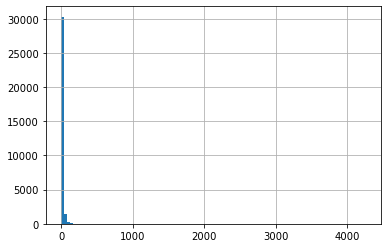

In [15]:
# the histogram of prep_time_seconds before removing outliers
orders['prep_time_minutes'].hist(bins=100)

In [16]:
perc_95 = orders['prep_time_seconds'].quantile(0.95)
perc_5 = orders['prep_time_seconds'].quantile(0.05)

In [17]:
orders = orders.query('prep_time_seconds <= @perc_95 and prep_time_seconds >= @perc_5')

In [18]:
# print the descriptive table again to make sure outliers were removed
orders.describe()

,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,prep_time_minutes
count,29158.000000,29158.000000,29158.000000,29158.000000,29158.000000
mean,26.103653,1265.371116,4.006791,920.363297,15.339380
std,15.862025,957.215330,2.303532,527.106528,8.785118
min,1.100000,3.000000,1.000000,116.000000,1.930000
25%,16.850000,408.000000,3.000000,549.000000,9.150000
50%,21.500000,1108.500000,3.000000,820.000000,13.670000
75%,30.300000,2106.000000,5.000000,1177.000000,19.620000
max,357.900000,3622.000000,38.000000,3021.000000,50.350000


<AxesSubplot:>

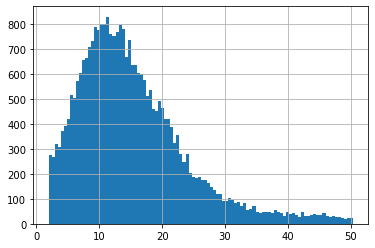

In [19]:
# the histogram of prep_time_seconds after removing outliers
orders['prep_time_minutes'].hist(bins=100)

From the table above we can see that 50% of the orders have a value lower that 21.5 gbp, have 3 items or less and it takes 13.6 minutes or less to prepare. The mean is higher than the median meaning that the distribution of order value, number of items and prep time is skewed. This should be taken into account later at the modeling stage.

In [20]:
# merge the orders dataframe and restaurants dataframe in order to have access to all the data in one place
orders = orders.merge(restaurants, left_on='restaurant_id', right_on='restaurant_id')

In [21]:
# check there are no missing values in the orders dataframe after merging
orders.isnull().sum().sum()

0

#### Check countries

The UK is the biggest market with the highest number of restaurants (82.14% of all the restaurants) and the highest number of orders (93.45% of all orders). Apart from from UK, there are 3 other markets: France, Germany, Ireland.

In [22]:
total_restaurants = len(orders['restaurant_id'].unique())
total_orders = len(orders)
orders.groupby('country').apply(lambda x: pd.Series([round(100*len(x['restaurant_id'].unique())/total_restaurants,2), 
                                                     round(100*len(x)/total_orders,2)], 
                                                    index=['n_restaurants', 'n_orders']))

,n_restaurants,n_orders
country,,
France,9.35,4.38
Germany,5.39,1.04
Ireland,3.12,1.13
UK,82.14,93.45


<AxesSubplot:xlabel='country', ylabel='prep_time_minutes'>

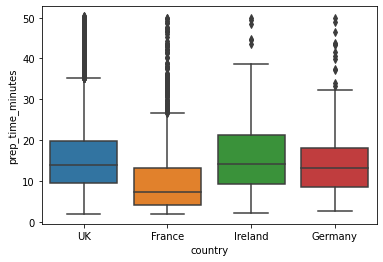

In [23]:
sns.boxplot(x='country', y='prep_time_minutes', data=orders)

From the boxplot above we can see that France tends to have lower prep time (median less than 10 minutes). For the other countries prep time tends to vary between 10-20 minutes. However there seem to be longs tails and there are around 25% of orders with prep time between around 30 and 50 minutes. This information should be taken into account at modelling stage.

#### Check cities

In [24]:
orders.groupby(['country', 'city']).apply(lambda x: pd.Series([len(x['restaurant_id'].unique()), len(x)], 
                                                    index=['n_restaurants', 'n_orders']))

n_restaurants  n_orders
country city                                
France  Paris                  156      1278
Germany Berlin                  76       285
        München                 14        18
Ireland Dublin                  52       330
UK      Birmingham              49       257
        Brighton                40       612
        Bristol                 15        77
        Cambridge               17       160
        Cardiff                  4         5
        Cheltenham               8        10
        Edinburgh               37       387
        Glasgow                 31       165
        Guildford                8       100
        Leeds                   23       203
        Leicester                8         9
        Liverpool               20       145
        London                 983     23406
        Manchester              70       881
        Nottingham              22       210
        Oxford                  23       502
        Reading                 11       116
        Southampton              2         2

The biggest cities in terms of number of restaurants and number of orders are London and Paris
There are some cities e.g. Southampton that have very few restaurants and orders and this information should 
probably be taken into account at modelling stage because there might not be enough data points (orders) for those cities.

In [25]:
orders['city'].value_counts()

London         23406
Paris           1278
Manchester       881
Brighton         612
Oxford           502
Edinburgh        387
Dublin           330
Berlin           285
Birmingham       257
Nottingham       210
Leeds            203
Glasgow          165
Cambridge        160
Liverpool        145
Reading          116
Guildford        100
Bristol           77
München           18
Cheltenham        10
Leicester          9
Cardiff            5
Southampton        2
Name: city, dtype: int64

<AxesSubplot:>

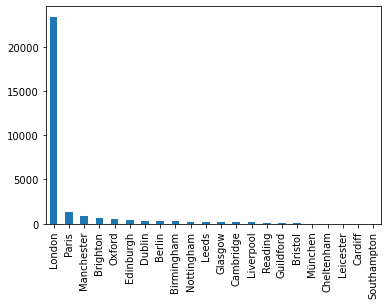

In [26]:
orders['city'].value_counts().plot.bar()

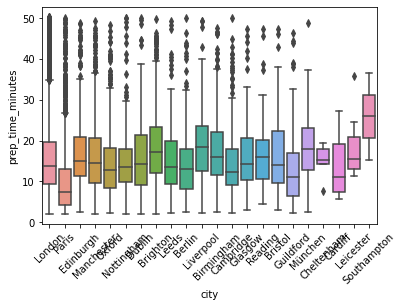

In [27]:
sns.boxplot(x='city', y='prep_time_minutes', data=orders)
_ = plt.xticks(rotation=45)

From the boxplot above we can see that Paris tends to have lower prep time, which we already observed earlier in the countries plot (Paris is the only city in France). Southhampton tends to have higher prep times, however it has only 2 data points. Cheltenham seems to have a small variation in prep time, however it has very few orders. 
For most of the cities prep time seems to vary between 10 and 20 minutes. 

It seems that the city may not give more additional information if we already know the country since for France for example we have only 1 city and most of the cities have similar range (apart from cities with very few data points). I decided to create a new category `other` for cities with very few orders (less than 18):München, Cheltenham, Leicester, Cardiff, Southampton.      

#### Check types of food

In [28]:
orders['type_of_food'].value_counts()

italian              4324
burgers              3716
thai                 2686
american             2152
japanese             1634
                     ... 
french lebanese         2
steakhouse              2
delicatessen            2
thaï / brunch           2
japanese peruvian       1
Name: type_of_food, Length: 82, dtype: int64

<AxesSubplot:>

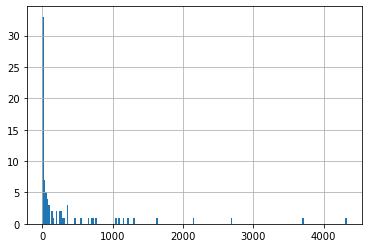

In [29]:
orders['type_of_food'].value_counts().hist(bins=200)
# plt.xlim(0,200)

There are 82 different types of food. Given that many of them are quite infrequent, they should probably be grouped into a smaller number of categories.

In [30]:
bins = [0, 30,  5000]
pd.DataFrame(pd.cut(orders['type_of_food'].value_counts(), bins)).value_counts()

type_of_food
(30, 5000]      44
(0, 30]         38
dtype: int64

I decided to group together the most infrequent types of food. The types of food for which there are less than 30 orders I will put them in a new category `other`

In [31]:
other_types_of_food = orders['type_of_food'].value_counts().to_frame('count').query('count < 30').index

In [32]:
types_of_food_dict = {f: 'other' if f in other_types_of_food else f for f in orders['type_of_food'].unique()}
types_of_food_dict

{'burritos': 'burritos',
 'chinese': 'chinese',
 'healthy': 'healthy',
 'dessert': 'dessert',
 'thai': 'thai',
 'american': 'american',
 'french': 'french',
 'persian': 'persian',
 'sandwiches': 'other',
 'mediterranean': 'mediterranean',
 'british': 'british',
 'italian': 'italian',
 'spanish': 'spanish',
 'lebanese': 'lebanese',
 'japanese': 'japanese',
 'burgers': 'burgers',
 'mexican': 'mexican',
 'chicken': 'chicken',
 'gluten free': 'other',
 'deli': 'deli',
 'turkish': 'turkish',
 'vietnamese': 'vietnamese',
 'argentinian': 'argentinian',
 'modern british': 'modern british',
 'bakery': 'bakery',
 'korean': 'korean',
 'pan asian': 'pan asian',
 'european': 'european',
 'indonesian': 'other',
 'indian': 'indian',
 'ramen': 'ramen',
 'australian': 'australian',
 'bbq': 'bbq',
 'sweet treats': 'other',
 'greek': 'greek',
 'peruvian': 'peruvian',
 'international': 'international',
 'north african': 'other',
 'juices': 'juices',
 'vegan': 'other',
 'irish': 'other',
 'middle eastern':

In [33]:
orders['type_of_food'] = orders['type_of_food'].map(types_of_food_dict)

In [34]:
# Now we have 45 types of food instead of 82
len(orders['type_of_food'].unique())

45

#### Check hour of the day and day of week

I decided to get the hour and day of the week and explore how does the distribution of prep time for different days of the week and different hours of the day.

In [35]:
orders['hour'] = [i.hour for i in orders['order_acknowledged_at']]
orders['day_of_week'] = [i.weekday() for i in orders['order_acknowledged_at']]

<AxesSubplot:xlabel='day_of_week', ylabel='prep_time_minutes'>

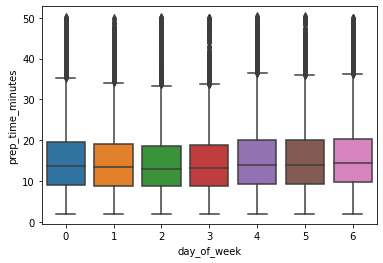

In [36]:
sns.boxplot(x='day_of_week', y='prep_time_minutes', data=orders)

In the box plot above 0 is Monday and 6 is Sunday. We can see that Wednesday has a slightly lower median and during the weekend (Friday, Saturday and Sunday) the median is a bit higher compared to other weekdays. The day of the week seems to give some information regarding prep time, so it should probably used as a feature during modelling. 

<AxesSubplot:xlabel='hour', ylabel='prep_time_minutes'>

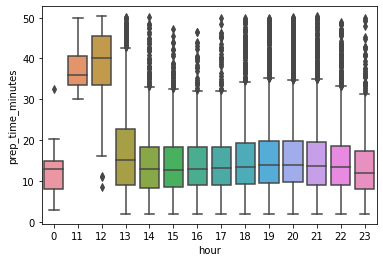

In [37]:
sns.boxplot(x='hour', y='prep_time_minutes', data=orders)

The hours of the day with the highest prep time seems to be 11 and 12, just before lunch time, when it takes between 35 and 45 minutes to prep an order. This might be because the restaurant might be busier during those hours and it might take them longer to prep the orders. The time of the day with the lowest prep time is 23, and that might be because the restaurants might be less busy so late in the night. The hour of the day seems to contain information about the prep time, so it should probably be used as a feature at modelling stage.

# 4. Feature engineering
In this section I work on feature engineering of categorical features and numerical features. 
- The categorical features include: `restaurant_id`, `type_of_food`, `day_of_week`, `hour`, `country`. The categorical features will be one-hot encoded. I decided not to use `city` as a feature since from the EDA the city does not seem to add new information on top of the country.
- Numerical features are `number_of_items` and `order_value_gbp` which were already in the original data.

Engineering new features is a good idea because it gives us the opportunity to extract useful information which at first might not be obvious or clear; for example the hour of the day or day of the week which is contained in the timestamps. If we wouldn't extract those features, the models would not be able to make use of some additional information which might be useful in predicting the preparation time.

### OneHotEncoding of categorical features

In [38]:
orders = one_hot_encode(orders, 'day_of_week')
orders = one_hot_encode(orders, 'hour')
orders = one_hot_encode(orders, 'country')
orders = one_hot_encode(orders, 'type_of_food')
orders = one_hot_encode(orders, 'restaurant_id')

# 4. Modelling
In this section I will model `prep_time_minutes` using the features in the previous section. 
- I split the data into train set and test set
- I use as baseline the average prep time in minutes in train set
- Initally I model the data using a simple model: Linear regression. I log transform the target because from the EDA we saw that the distribution of `prep_time_minutes` is skewed
- The error of the model could go in two directions: the real prep time is longer than the estimated time or the real prep time is shorter than the estimated time. In both cases the error will have a negative business impact and for each case we should have metrics than quantify the impact. However at this stage I focused on a ML model metric and I chose as evaluation metric RMSE (root mean squared error) because it's regression problem. I decided not to go for Mean Squared Error because the squared error is not easily interpretable. Another option would be Mean Absolute Error. However, RMSE penalises more the cases when the error is large (because it squares the error) and less the cases when the error is small. This is desirable since a small error of for example a couple of minutes is not expected to impact the delivery system as much as an error of let's say 15 minutes.
- I regularise the linear regression using L2 regularisation.
- I try different sets of features with LR .
- Then I move on to more complex models: Random Forest.

In [39]:
orders.columns[:30]

Index(['order_acknowledged_at', 'order_ready_at', 'order_value_gbp',
       'restaurant_id', 'number_of_items', 'prep_time_seconds',
       'prep_time_minutes', 'country', 'city', 'type_of_food', 'hour',
       'day_of_week', 'is_day_of_week_1', 'is_day_of_week_2',
       'is_day_of_week_3', 'is_day_of_week_4', 'is_day_of_week_5',
       'is_day_of_week_6', 'is_hour_11', 'is_hour_12', 'is_hour_13',
       'is_hour_14', 'is_hour_15', 'is_hour_16', 'is_hour_17', 'is_hour_18',
       'is_hour_19', 'is_hour_20', 'is_hour_21', 'is_hour_22'],
      dtype='object')

In [40]:
features = orders.drop(['order_acknowledged_at', 'order_ready_at', 'prep_time_seconds', 
                       'prep_time_minutes', 'country', 'city', 'type_of_food', 'hour', 'day_of_week', 
                       'restaurant_id'], axis=1)
target = orders[['prep_time_minutes']]

In [41]:
X_train, X_test, y_train, y_test = split_data(features, target, test_size=0.33)

### 4.1 Baseline
I will use as baseline the average prep time in the train set which is 15.33 minutes

In [42]:
# the average prep time in the train set
baseline = round(y_train['prep_time_minutes'].mean(), 2)
baseline

15.33

In [43]:
# RMSE for the baseline in the test set is 8.79 minutes
compute_error([baseline] * len(y_test), y_test)

8.79

### 4.2 Linear Regression
Given that the dataset is small, I started the modelling with a simple liner model. Because distribution of the prep time was skewed (as observed in the EDA) I did a log transform of the prep time and modelled that. At model evaluation stage I transformed the prediction back with the exponential transformation. I scaled the numerical features with a standard scaler using the mean and std in the train set.

In [44]:
y_train_log = np.log(y_train)

In [45]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test, features_to_scale=['order_value_gbp', 
                                                                               'number_of_items'])

#### LR with only numerical features

In [46]:
columns_to_train = ['order_value_gbp', 'number_of_items']
linear_reg = LinearRegression()
train_model(X_train_scaled[columns_to_train], y_train_log, linear_reg)
print('Train error', compute_error(np.exp(linear_reg.predict(X_train_scaled[columns_to_train])), y_train))
print('Test Error', compute_error(np.exp(linear_reg.predict(X_test_scaled[columns_to_train])), y_test))

Train error 8.98
Test Error 9.23


The RMSE of the linear regression model with only numerical features is 9.23 minutes which is worse than the RMSE of the baseline model 8.79 minutes. This is expected since the model does not have any information about the restaurant.

#### LR with numerical features and the categorical features: `restaurant_id`, `type_of_food`,`country`,`day_of_week`, `hour`

In [47]:
linear_reg = LinearRegression()
train_model(X_train_scaled, y_train_log, linear_reg)
print('Train error', compute_error(np.exp(linear_reg.predict(X_train_scaled)), y_train))
print('Test Error', compute_error(np.exp(linear_reg.predict(X_test_scaled)), y_test))

Train error 7.24
Test Error 7.93


Adding the categorical features improves the model: the error goes from 8.31 (baseline) to 7.93 minutes: 4.5% improvement in error. 

#### LR: removing `country`
I removed the `country` feature to see how it affects model performance.

In [48]:
columns_to_train = [f for f in X_train_scaled.columns if 'is_country' not in f]
linear_reg = LinearRegression()
train_model(X_train_scaled[columns_to_train], y_train_log, linear_reg)
print('Train error', compute_error(np.exp(linear_reg.predict(X_train_scaled[columns_to_train])), y_train))
print('Test Error', compute_error(np.exp(linear_reg.predict(X_test_scaled[columns_to_train])), y_test))

Train error 7.24
Test Error 7.92


The country fetaure does not seem to impact the model a lot. The train error does not change and the test error decreases from 7.93 to 7.92: 0.12% improvement in error. I decided to drop the `country` as a feature.
There is a bit of variance between train and test set since the train error is a bit smaller than the test error. So, to tackle the variance in the next step I add l2 regularisation to the Linear regression (Ridge regression)

### 4.3 Ridge Regression

In [49]:
columns_to_train = [f for f in X_train_scaled.columns if 'is_country' not in f]
ridge_reg = Ridge(alpha=0.5, random_state=1)
train_model(X_train_scaled[columns_to_train], y_train_log, ridge_reg)
print('Train error', compute_error(np.exp(ridge_reg.predict(X_train_scaled[columns_to_train])), y_train))
print('Test error', compute_error(np.exp(ridge_reg.predict(X_test_scaled[columns_to_train])), y_test))

Train error 7.26
Test error 7.85


In [50]:
columns_to_train = [f for f in X_train_scaled.columns if 'is_country' not in f]
ridge_reg = Ridge(alpha=1, random_state=1)
train_model(X_train_scaled[columns_to_train], y_train_log, ridge_reg)
print('Train error', compute_error(np.exp(ridge_reg.predict(X_train_scaled[columns_to_train])), y_train))
print('Test error', compute_error(np.exp(ridge_reg.predict(X_test_scaled[columns_to_train])), y_test))

Train error 7.3
Test error 7.82


In [51]:
columns_to_train = [f for f in X_train_scaled.columns if 'is_country' not in f]
ridge_reg = Ridge(alpha=50, random_state=1)
train_model(X_train_scaled[columns_to_train], y_train_log, ridge_reg)
print('Train error', compute_error(np.exp(ridge_reg.predict(X_train_scaled[columns_to_train])), y_train))
print('Test error', compute_error(np.exp(ridge_reg.predict(X_test_scaled[columns_to_train])), y_test))

Train error 7.93
Test error 8.15


The regularisation parameter alpha controls the strength of regularization. Initally when increasing the value of alpha, the stronger the regularisation, the train error increases and test error decreases, meaning that the LR model with regularisation was overfitting. However, for values of alpha that are too high (e.g. 50) we can see that the train error increases and the test error increases, meaning that the model is underfitting because the regularisation is too strong.
I run a grid search over the regularisation parameter `alpha` to see at which point we start underfitting.

In [52]:
alphas = list(np.arange(0.1, 1, 0.3))
alphas.extend(list(np.arange(1, 210, 10)))
alphas = np.round(alphas, 2)
errors = pd.DataFrame(index=alphas, columns=['train_error', 'test_error'])
for alpha in alphas:
    ridge_reg = Ridge(alpha=alpha, random_state=1)
    train_model(X_train_scaled, y_train_log, ridge_reg)
    errors.loc[alpha] = compute_error(np.exp(ridge_reg.predict(X_train_scaled)), y_train), compute_error(np.exp(ridge_reg.predict(X_test_scaled)), y_test)

In [53]:
errors

,train_error,test_error
0.1,7.24,7.9
0.4,7.26,7.85
0.7,7.28,7.83
1.0,7.29,7.81
11.0,7.57,7.86
21.0,7.68,7.93
31.0,7.76,7.99
41.0,7.82,8.05
51.0,7.88,8.09
61.0,7.92,8.13


<AxesSubplot:>

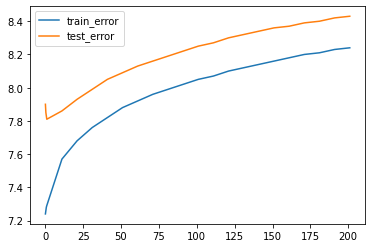

In [54]:
errors.plot()

The test error is minimised for alpha=1 with RMSE 7.81 minutes (from 7.92 for LR without L2) meaning that Ridge Regression model is better than LR: 1.38% improvement in performance.

### 4.4 Random Forest
Since the linear models did not perform very well I decided to try a more complex model. We observed skewed dictribution in the data and we have many categorical features I decided to try Random Forest Regressor. We do not need to scale the data or perform log transformations. All the numerical and categorical features engineered in the previous stages were used to train the model.

In [55]:
rf_reg = RandomForestRegressor(oob_score=True, random_state=1)
train_model(X_train, y_train, rf_reg)
print('Train error oob', compute_error(rf_reg.oob_prediction_, y_train))
print('Test error', compute_error(rf_reg.predict(X_test), y_test))

Train error oob 7.98
Test error 7.96


The RF model has a test error of 7.96 minutes which is higher than Ridge regressior with test RMSE 7.81 minutes. The train error of RF is also high 7.98 minutes.

### Feature importance

In [56]:
feature_importances = pd.DataFrame(rf_reg.feature_importances_, index=rf_reg.feature_names_in_, columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
order_value_gbp,0.176251
is_hour_12,0.079820
number_of_items,0.044572
is_hour_20,0.014073
is_hour_21,0.013428
...,...
is_restaurant_id_2771,0.000000
is_restaurant_id_2786,0.000000
is_restaurant_id_2787,0.000000
is_restaurant_id_2920,0.000000


<AxesSubplot:>

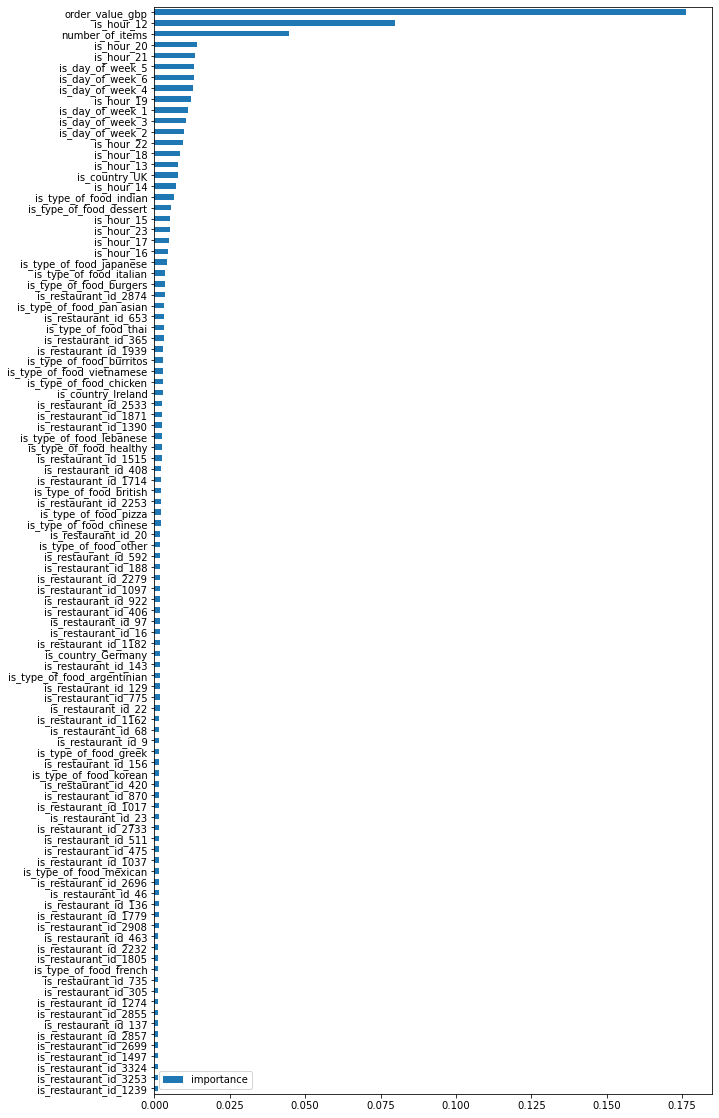

In [57]:
fig, ax = plt.subplots(figsize=(10,20))
feature_importances.sort_values('importance', ascending=True).iloc[-100:].plot.barh(ax=ax)

In [58]:
orders['restaurant_id'].value_counts().shape

(1669,)

The most important features for RF are `order_value_gbp`, `number_of_items` and hour and day of week features: more precisely the features that show whether the hour of the day is 12 (lunch time), or whether the hour of the day is 19, 20, 21 (dinner time). Most important day of week features are whether it is Friday, Saturday and Sunday. Whether the country is UK seems to be an important feature. Some type_of_food features also seem to be important (indian and dessert).


There are features with 0 importance and all of them are `restaurant_id` features. The `restaurant_id` feature has 1669 categories, which might be too many categories for the RF model to make good use of it.

In [59]:
# restaurant_id features with 0 importance
print([f for f in feature_importances.query('importance == 0').index if 'is_restaurant_id' not in f])
feature_importances.query('importance == 0')

[]


,importance
is_restaurant_id_181,0.0
is_restaurant_id_358,0.0
is_restaurant_id_453,0.0
is_restaurant_id_497,0.0
is_restaurant_id_557,0.0
...,...
is_restaurant_id_3483,0.0
is_restaurant_id_3517,0.0
is_restaurant_id_3541,0.0
is_restaurant_id_3559,0.0


# 5. Final model recommendation
My recommendation is to go with the Linear Model with L2 regularisation model aplha=1. This model improves the error from 8.79 to 7.81 minutes, an incremental improvement of 11.1%. I recommend to put the model in production for testing to better understand the business impact. I suggest to randomly split the customers in 2 groups and use the baseline model with one group and the new model with the other. 

I expect the model to impact the customers and riders experience, so I suggest to track metrics which measure both: e.g. the acceptance rate of the riders - if it goes up in the group with the new model, the model is having a good impact; the nr of complaints from customers - if there is an increase in complaints in the group with the new model, the model is not doing well; the volume ordered by customers - if it goes up in the group with the new model, then the model is doing well.

# 6. Next steps

If I had more time to work on this project, I would do some further exploration in the following directions:
- I would investigate more thoroughly the types of food. In this notebook I created a new food category `other` where I put the types of food for which we had very little data. However, some types of food are very similar and could be aggregated in one category (for example burritos and mexican could possibly be in the same category)
- I would investigate more the distribution of prep_time_seconds and the outliers to try and understand better the reason behind the extreme prep time values, how the dropping of outliers affects modelling and what would be a smarter way to detect outliers.
- I would try different combinations of features in the Ridge Regression to find the optimal set of features and to better understand which features are more important
- I would add new features that could potentially improve the model performance: for example how many orders does the restaurant have pending in an attempt to estimate how busy is the restaurant at a certain time, or using other average metrics per restaurant e.g. average nr of items per order for each restaurant etc. However, I would be careful when computing such features to make sure there is no data leakage.
- In the RF model, many of the one hot encoded features for `restaurant_id` have 0 or very low importance. There are 1669 restaurant ids resulting in 1668 one hot encoded features, so as a next step I would look more into other ways we can better encode the restaurant id in the model e.g. using the average prep time of each restaurant in the train set as a proxy. 


# 7. Business implications

The preparation time prediction model and its peformance will have significant impact on the whole Deliveroo system and business. Having an inaccurate model will affect the business negatively in several different ways. It's very important that the model does not over-estimate nor under-estimate the preparation time. Underestimation of the prep time will result in riders wasting time by waiting at the restaurants for orders to be completed, time that could have been used by riders to pick up and deliver other orders. This might result in an increase of riders dissatisfaction. 

In case of prep time overestimation, the riders will not be at the restaurants in time to pick up the order but instead they will arrive late, leaving the prepared order waiting at the restaurant. This means it will take longer for the order to reach the customer starting from the moment the order was made and the customer will not receive very fresh/warm food. Customer satisfaction will go down affecting customer rentention and some customers might complain and even ask for refund if the service and the food they received was not satisactory. 
A good prep time prediction might also help to estimate how many riders will be busy and how many riders will be free at a certain moment and planning accordingly. 

A good prep time prediction model will overall improve customer and riders experience and the experience of all the parties involved as well as make the whole Deliveroo system more efficient. 